Na potrzeby realizacji dwóch zadań:
- pn. 'Pipeline' z modułu 16, submodułu 16.5 oraz
- pn. 'hiperparametry' z modułu 16, submodułu 16.6

wykorzystałam zbiór danych o chorych na cukrzycę z modułu 14 "Supervised Learning - klasyfikacja" (zbiór zawiera informacje diagnostyczne dotyczące pacjentów, u których wykonano badania w kierunku cukrzycy).

Oba zadania realizuję w ramach jednego pliku/projektu, który zamieściłam na GitHub.

# Zadanie 'Pipeline'

Import bibliotek

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

Zaimportowanie zbioru danych

In [3]:
dataset = pd.read_csv('diabetes.csv')
dataset

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
...,...,...,...,...,...,...,...,...,...,...
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0


Sprawdzenie kompletności danych

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


Z powyższego wynika, że dane są kompletne

Podział danych na zbiór treningowy oraz testowy. Zmienną objaśnianą (y) jest informacja o tym czy dany pacjent jest chory na cukrzycę, czy nie (kolumna 'Diabetic'; wartość '0' - nie chory, wartość '1' - chory)

In [26]:
X = dataset.drop(['Diabetic'], axis=1).copy()
y = dataset['Diabetic'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

Wskazanie kolumn z danymi numerycznymi

In [30]:
num_features1 = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']

Wyliczenie współczynnika punktowo-dwuseryjnego w celu sprawdzenia korelacji pomiędzy zmiennymi objaśniajacymi X, a zmienną objaśnianą Y

In [29]:
from scipy import stats

corr_dict = {}
for col in num_features1:
    corr_dict[col] = stats.pointbiserialr(X[col], y)[0]
pd.Series(corr_dict).sort_values(ascending=False)

Pregnancies               0.407315
Age                       0.342605
SerumInsulin              0.247375
BMI                       0.210508
DiabetesPedigree          0.170302
TricepsThickness          0.152505
PlasmaGlucose             0.128004
DiastolicBloodPressure    0.091307
dtype: float64

Z powyższego wynika, że nasilniejsza korelacja zachodzi pomiędzy zmienną objaśnianą y, a zmiennymi objaśniającymi X takimi jak: Pregnancies, Age, SerumInsulin, BMI. Dlatego też w dalszych wyliczeniach tylko te cztery będą brane pod uwagę.

In [31]:
num_features = ['Pregnancies', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']

Kolumna z danymi kategorycznymi

In [32]:
cat_features = ['Diabetic']

Stworzenie Pipeline dla zmiennych numerycznych i kategorycznych

In [33]:
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_features),
    ('categorical_preprocessing', cat_features)
])

Połączenie Pipeline z modelem regresji logistycznej. Trenowanie modelu na zbiorze treningowym, a następnie prognozowanie na zbiorze testowym i ewaluacja

In [39]:
num_features = ['Pregnancies', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']
cat_features = ['Diabetic']

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_features),
    ('categorical_preprocessing', cat_features)
])

model_pipeline_v1 = Pipeline(steps=[('model', LogisticRegression(max_iter=10000))])

In [40]:
model_pipeline_v1.fit(X_train, y_train)

Pipeline(steps=[('model', LogisticRegression(max_iter=10000))])

Ocena modelu v1 (z wykorzystaniem funkcji z modułu 14 pn. 'Supervised Learning - klasyfikacja')

              precision    recall  f1-score   support

           0       0.67      1.00      0.80      2500
           1       0.00      0.00      0.00      1250

    accuracy                           0.67      3750
   macro avg       0.33      0.50      0.40      3750
weighted avg       0.44      0.67      0.53      3750



C:\Users\marta.zegota\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marta.zegota\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marta.zegota\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

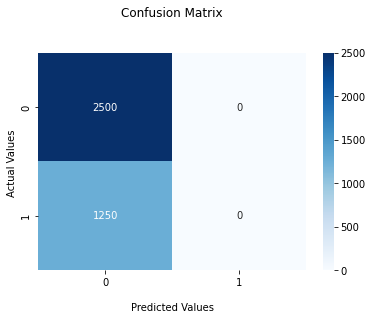

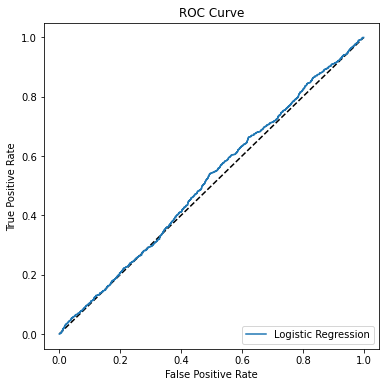

C:\Users\marta.zegota\AppData\Local\Temp\ipykernel_61684\3082216382.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Logistic Regression,0.0,0.514659


In [41]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################

    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
                                                 ignore_index=True)
    return metrics_dataframe

calculate_metrics(model_pipeline_v1, 'Logistic Regression', X_test, y_test)

Zależności mogą być nieliniowe dla zmiennych numerycznych, dlatego należy standaryzować zmienne numeryczne. Część zmiennych będzie ze sobą skorelowana i będzie niosła tę samą informację, dlatego stosuję PCA – analizę głównych składowych. Po jej wyniku dane nie muszą być wyskalowane, dlatego ponownie standaryzuję dane.

In [42]:
num_features = ['Pregnancies', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']
cat_features = ['Diabetic']

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

model_pipeline_v2 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline_v2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['Pregnancies',
                                                   'SerumInsulin', 'BMI',
                                                   'DiabetesPedigree',
                                                   'Age'])])),
                ('model', LogisticRegression(max_iter=10000))])

Ocena modelu v2

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      2500
           1       0.75      0.51      0.61      1250

    accuracy                           0.78      3750
   macro avg       0.77      0.71      0.73      3750
weighted avg       0.77      0.78      0.77      3750



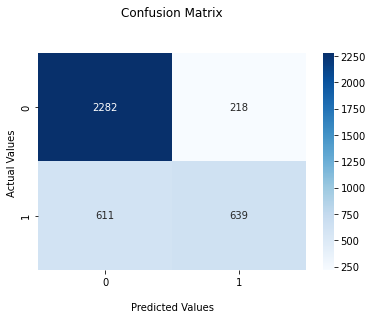

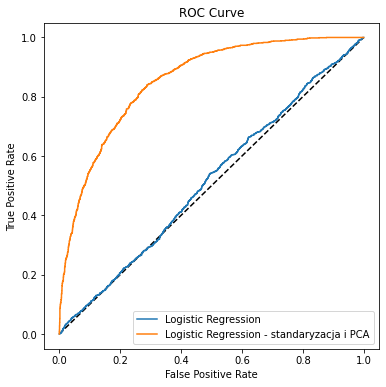

C:\Users\marta.zegota\AppData\Local\Temp\ipykernel_61684\3082216382.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Logistic Regression,0.0,0.514659
1,Logistic Regression - standaryzacja i PCA,0.60655,0.853468


In [43]:
calculate_metrics(model_pipeline_v2, 'Logistic Regression - standaryzacja i PCA', X_test, y_test)

Z powyższej ewaluacji widać, że po dodaniu etapów w procesie uczenia modelu wyniki znaczaco się poprawiły.
Po zastosowaniu standaryzacji i analizy głównych składowych wyniki modelu również są lepsze od tych osiągniętych przy okazji trenowania modelu regresji logistycznej w module 14.

# Zadanie 'hiperparametry'

Utworzenie nowego modelu - z wyborem hiperparametrów

In [44]:
model_pipeline_v3 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

Lista hiperparametrów modelu

In [21]:
list(model_pipeline_v3.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__numeric_preprocessing',
 'preprocessor__numeric_preprocessing__memory',
 'preprocessor__numeric_preprocessing__steps',
 'preprocessor__numeric_preprocessing__verbose',
 'preprocessor__numeric_preprocessing__polynomial_features',
 'preprocessor__numeric_preprocessing__scaler_1',
 'preprocessor__numeric_preprocessing__pca',
 'preprocessor__numeric_preprocessing__scaler_2',
 'preprocessor__numeric_preprocessing__polynomial_features__degree',
 'preprocessor__numeric_preprocessing__polynomial_features__include_bias',
 'preprocessor__numeric_preprocessing__polynomial_features__interaction_only',
 'preprocessor__numeric_preprocessing__polynomial_features__order',
 'preprocessor__numeric_preproce

Stworzenie GridSearch dla Pipeline z modelem, wybór parametrów i trenowanie modelu

In [ ]:
params = {
    'preprocessor__numeric_preprocessing__polynomial_features__degree': [1, 2, 3, 4],
    'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.90, 0.95, 0.99, 0.99999],
    'model__C': np.logspace(-4, 4, 50)
}

grid_search = GridSearchCV(model_pipeline_v3, params, cv=10, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Wybrane hiperparametry: ', grid_search.best_params_)
model_v3 = grid_search.best_estimator_

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


Ocena modelu v3

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2500
           1       0.83      0.83      0.83      1250

    accuracy                           0.89      3750
   macro avg       0.87      0.87      0.87      3750
weighted avg       0.89      0.89      0.89      3750



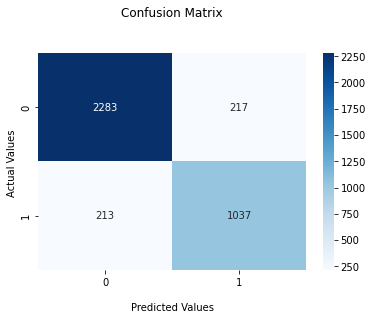

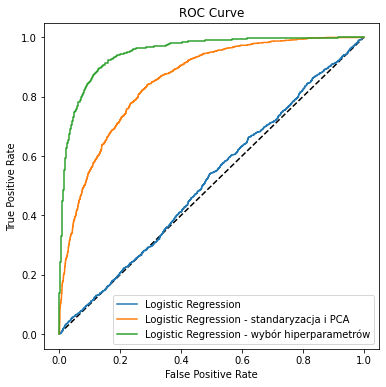

C:\Users\marta.zegota\AppData\Local\Temp\ipykernel_61684\3082216382.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Logistic Regression,0.0,0.514659
1,Logistic Regression - standaryzacja i PCA,0.60655,0.853468
2,Logistic Regression - wybór hiperparametrów,0.828275,0.949755


In [23]:
calculate_metrics(model_v3, 'Logistic Regression - wybór hiperparametrów', X_test, y_test)

Wyniki są znacząco lepsze w przypadku modelu v3 z wyborem hiperparametrów w porównaniu do modelu v2 z narzuconymi konkretnymi wartościami.